In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import cifar10

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE

import random

import seaborn as sns

#BAE 연구실 작성 자료
* 유출 금지!

#Linearly Separable & Un-separable

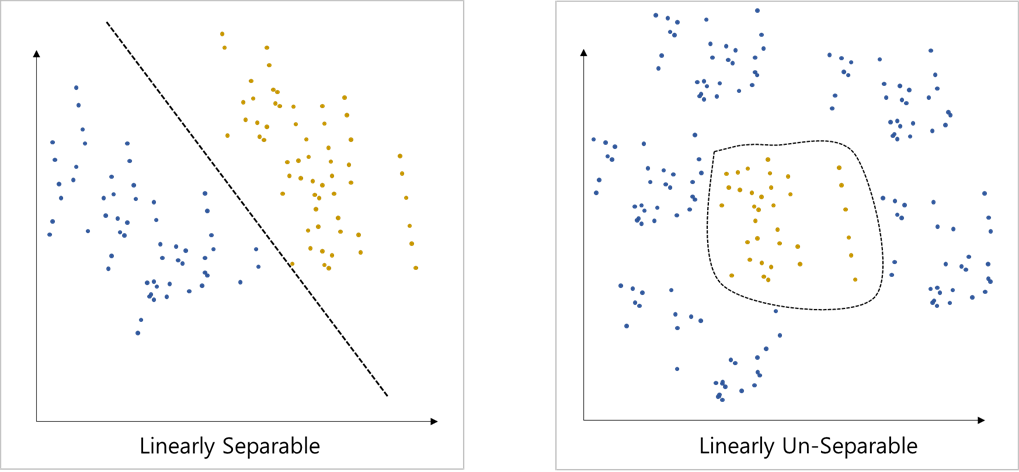

#Linearly Un-Separable 문제를 해결하는 방법

### 1. Learning non-linear function
* 예측 모델이 많은 파라미터(가중치)를 가지며, 이를 최적화 하는 것은 쉽지 않음

# ***2. Data transformation***
* 특정한 기준(유사도 등)을 바탕으로 입력 데이터를 선형 분리가 가능하도록 변환
 * 예측 모델의 파라미터가 적어, 최적화가 쉬움

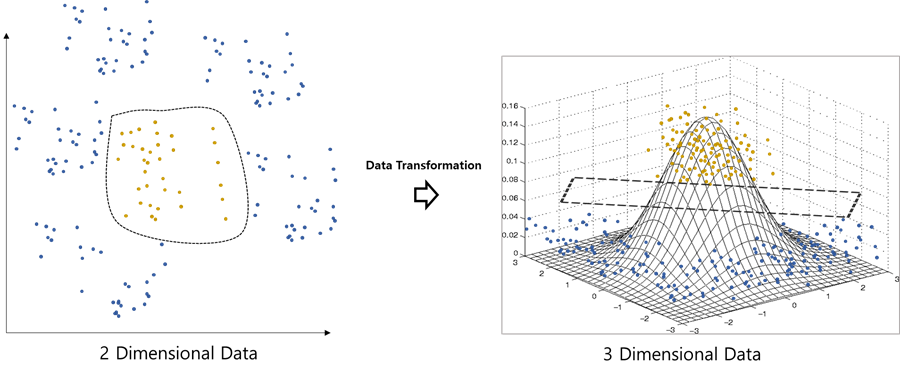

# 그렇다면, 어떻게 데이터를 변환할 것인가?

* ### 자연어 처리와 같은 다양한 분야에서는 의미론적인 유사도를 바탕으로 데이터를 변환함

---

### Metric Learning: 비 선형 공간에 표현된 입력 데이터 사이에 대한 유사도를 학습하는 것을 목적으로 함

* 데이터 사이에 존재하는 의미론적인 유사도를 학습하는 것!

* 비 선형 공간에 변환된 입력 데이터를 선형 분리가 가능하도록 만들어, 예측 성능을 향상

* 주로 활용되는 분야
 * 많은 분야에 적용 가능하지만, 특히 안면 인식과 같은 분야에서 활발한 연구가 진행됨

#왜 안면 인식에서 주로 활용되는가?

* 안면 인식이란, 스마트폰 등의 서비스에서 보안과 같은 목적으로 활용될 수 있음
* softmax 함수를 활용한 다중 분류 문제로 해결할 경우, 닫힌 데이터셋에서는 활용 가능할 수 있음. 하지만, Label의 종류는 매우 다양하기 때문에 학습되지 않은 새로운 Label에 대해서는 강건한 예측이 불가능함
 * 해결책: Metric Learning을 활용하여 데이터 사이에 유사도를 학습하고, 유사도 점수(임계값) 혹은 K-NN 등과 같은 알고리즘을 활용하여 문제 해결

# *실습의 목적*
* Metric Learning을 활용하여 데이터를 잠재 공간으로 변환하고, 이를 시각적으로 확인

---

# *실습 내용*
* **Siamese Network**
 * (Convolutional Network)
* **Contrastive Loss Function**
 * (Label을 활용하여 의미론적인 유사도 반영)
* **Data Sampling**
 * (semi-hard mining의 필요성)

In [2]:
# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 클래스 레이블 정의
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
#len(np.where(y_train == 5)[0])

x_train = np.delete(x_train, np.where(y_train >= 5)[0], axis = 0)
y_train = np.delete(y_train, np.where(y_train >= 5)[0]).reshape(-1, 1)

x_test = np.delete(x_test, np.where(y_test >= 5)[0], axis = 0)
y_test = np.delete(y_test, np.where(y_test >= 5)[0]).reshape(-1, 1)

#y_train.delete(np.where(y_train >= 5)[0])

In [4]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(25000, 32, 32, 3)
(25000, 1)
(5000, 32, 32, 3)
(5000, 1)


In [5]:
print('Training dset')
print('Min: ', x_train.min())
print('Max: ', x_train.max())
print('Mean: ', np.round(x_train.mean(), 2))
print('Std: ', np.round(x_train.std(), 2), '\n\n')

print('Test dset')
print('Min: ', x_test.min())
print('Max: ', x_test.max())
print('Mean: ', np.round(x_test.mean(), 2))
print('Std: ', np.round(x_test.std(), 2))

Training dset
Min:  0
Max:  255
Mean:  121.3
Std:  63.86 


Test dset
Min:  0
Max:  255
Mean:  121.69
Std:  63.66


In [6]:
x_train = x_train / 255
x_test = x_test / 255

In [7]:
x_train.shape

(25000, 32, 32, 3)

In [8]:
print('학습 데이터 입력 차원: ', x_train.shape, '\n', '출력 차원: ', y_train.shape)

학습 데이터 입력 차원:  (25000, 32, 32, 3) 
 출력 차원:  (25000, 1)


In [9]:
d = dict()
for i in range(5):
  d[i] = class_labels[i]

In [10]:
print(list(d.values()), '\n', list(d.keys()))

['airplane', 'automobile', 'bird', 'cat', 'deer'] 
 [0, 1, 2, 3, 4]


In [11]:
print(d)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer'}


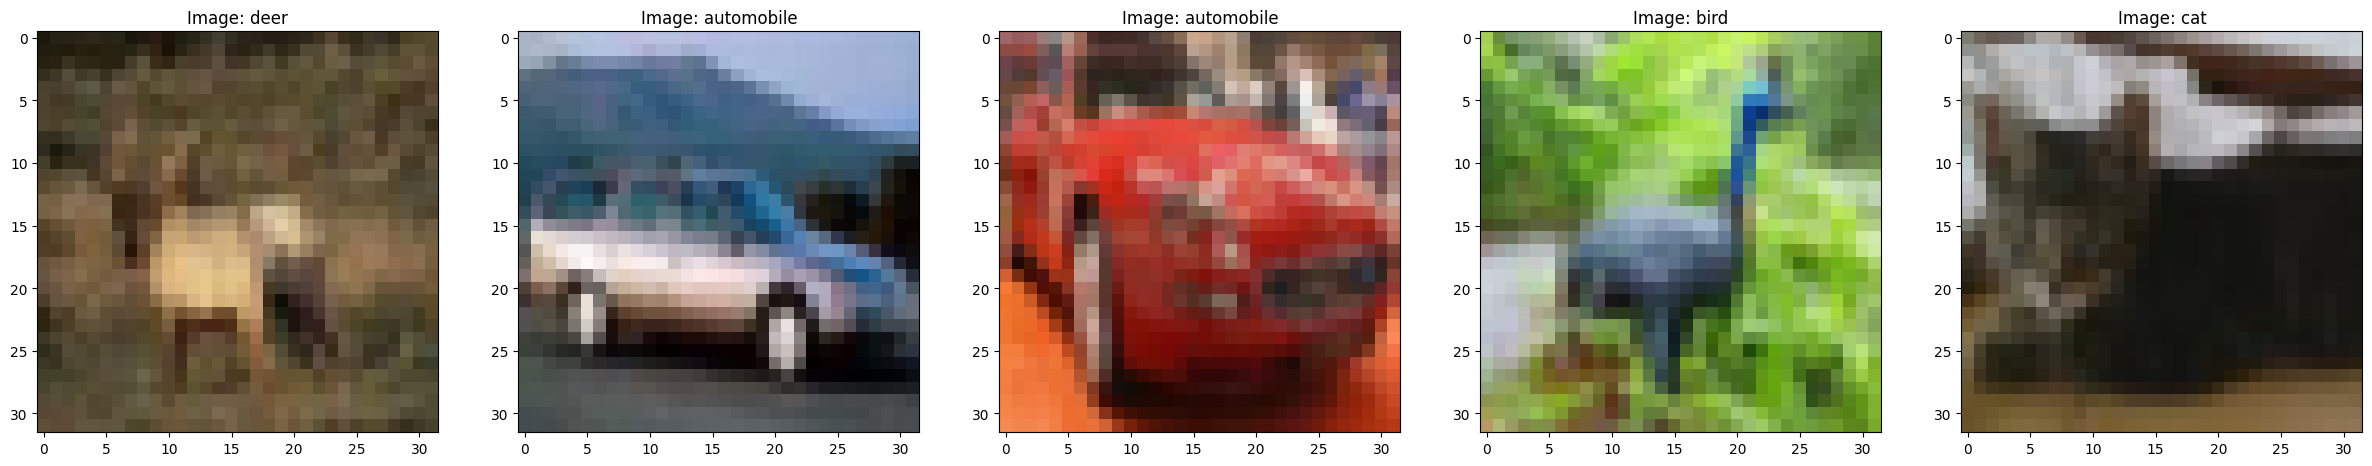

In [12]:
plt.figure(figsize = (30, 20)) # 전체 그림의 크기 설정

for i in range(5): # 5번 반복
  plt.subplot(1, 5, i+1) # 총 5개 그림(1행 5열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow(x_train[i]) # index에 해당하는 그림 출력
  plt.title('Image: '+d[y_train[i].reshape(1)[0]]) # 그림의 제목은 해당 그림의 정답으로

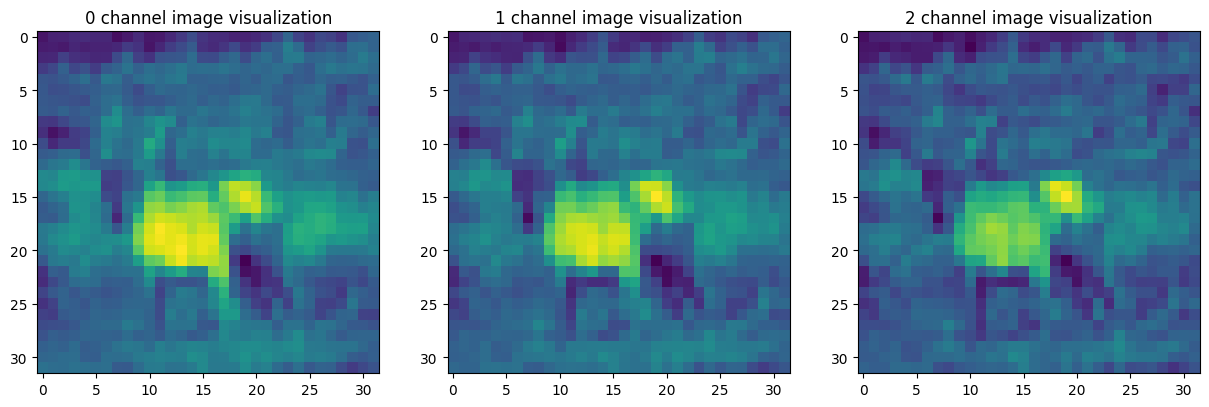

In [13]:
#deer 채널 별 시각화

plt.figure(figsize = (15, 12))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(x_train[0][:, :, i])
  plt.title(str(i)+' channel image visualization')

In [14]:
x_train[0][:, :, 0] # 0번째 그림에서 총 3개 중 첫번째 채널(RGB)에 있는 데이터
#x_train[0][:, :, 1] # 0번째 그림에서 총 3개 중 첫번째 채널(RGB)에 있는 데이터
#x_train[0][:, :, 2] # 0번째 그림에서 총 3개 중 첫번째 채널(RGB)에 있는 데이터

array([[0.10980392, 0.14509804, 0.14901961, ..., 0.29803922, 0.31764706,
        0.33333333],
       [0.12941176, 0.13333333, 0.1254902 , ..., 0.37254902, 0.37647059,
        0.33333333],
       [0.15294118, 0.15686275, 0.22352941, ..., 0.36470588, 0.41960784,
        0.37254902],
       ...,
       [0.3254902 , 0.34117647, 0.32941176, ..., 0.38823529, 0.35294118,
        0.31764706],
       [0.34509804, 0.35294118, 0.36470588, ..., 0.31372549, 0.29803922,
        0.32156863],
       [0.38039216, 0.36862745, 0.36470588, ..., 0.21176471, 0.24705882,
        0.28235294]])

#Dataset
* Data Sampling

In [15]:
class Img_dset(Dataset):

  def __init__(self, x, y, d, Training_):
    self.x = x
    self.y = y

    self.sample = list()

    self.List = list(d.keys())

    self.Training_ = Training_

    if self.Training_ == False:

      print('Test Data Loader')

      self.tx1 = self.x[:len(self.x)//2]
      self.tx2 = self.x[len(self.x)//2:]

      self.ty1 = self.y[:len(self.x)//2]
      self.ty2 = self.y[len(self.x)//2:]

      for t in range(len(self.tx1)):
        self.sample.append((torch.tensor(self.tx1[t], dtype = torch.float32),
                            torch.tensor(self.tx2[t], dtype = torch.float32), self.ty1[t], self.ty2[t]))

    else:

      print('Train Data Loader')

      for _ in list(self.List):
        #Positive sample
        xx = self.x[np.where(self.y == _)[0]]
        yy = self.y[np.where(self.y == _)[0]]
        
        x1 = xx[:len(xx)//2]
        x2 = xx[len(xx)//2:]

        y1 = yy[:len(yy)//2]
        y2 = yy[len(yy)//2:]

        for pos_samp in range(len(x1)//2):
          self.sample.append((torch.tensor(x1[pos_samp], dtype = torch.float32),
                              torch.tensor(x2[pos_samp], dtype = torch.float32),
                              torch.tensor([0])))
        
        #Negative sample
        neg_xx = self.x[np.where(self.y != _)[0]]
        neg_x1 = neg_xx[:len(neg_xx)//8]

        print(x1.shape)
        print(neg_x1.shape)

        for neg_samp in range(len(neg_x1)):
          rand = random.randint(0, len(x1)-1)
          self.sample.append((torch.tensor(x1[rand], dtype = torch.float32),
                              torch.tensor(neg_x1[neg_samp], dtype = torch.float32),
                              torch.tensor([1])))

  def __len__(self):
    return len(self.sample)

  def __getitem__(self, index):

    '''
    1) 두 이미지의 Label이 동일한 경우, 0으로 지정
    2) 두 이미지의 Label이 다른 경우, 1으로 지정
    '''
    
    return self.sample[index]

In [16]:
#x_train[np.where(y_train == 3)[0]].shape
#x_train[y_train[np.where(y_train == 3)[0]]].shape
#x_train[np.where(y_train == 3)[0]][:200]

In [17]:
dset = Img_dset(x_train, y_train, d, Training_ = True)
trainloader = DataLoader(dset, batch_size = 128, shuffle = True, drop_last = True)

test_dset = Img_dset(x_test[:2000, :, :, :], y_test[:2000, :], d, Training_ = False)
testloader = DataLoader(test_dset, batch_size = 1, shuffle = False)

del dset
del test_dset

Train Data Loader
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)
Test Data Loader


In [18]:
for idx, data in enumerate(trainloader):
  Sample = data
  X1 = Sample[0]#.squeeze(1)#.permute(0, 3, 1, 2)
  X2 = Sample[1]#.squeeze(1)#.permute(0, 3, 1, 2)
  Y = Sample[2]
  break
  #pos_x1, pos_x2, pos_y, neg_x1, neg_x2, neg_y = data
  #break
  #pos_x1 = pos_x1.permute(0, 3, 1, 2)
  #pos_x2 = pos_x2.permute(0, 3, 1, 2)
  #neg_x1 = neg_x1.permute(0, 3, 1, 2)
  #neg_x2 = neg_x2.permute(0, 3, 1, 2)
  #x, y = data
  #x = x.permute(0, 3, 1, 2)
  #print(x.shape)
  #print(y.shape)

In [19]:
print(X1.shape)# sample 1
print(X2.shape)# sample 2
print(Y.shape)# positive or negative

torch.Size([128, 32, 32, 3])
torch.Size([128, 32, 32, 3])
torch.Size([128, 1])


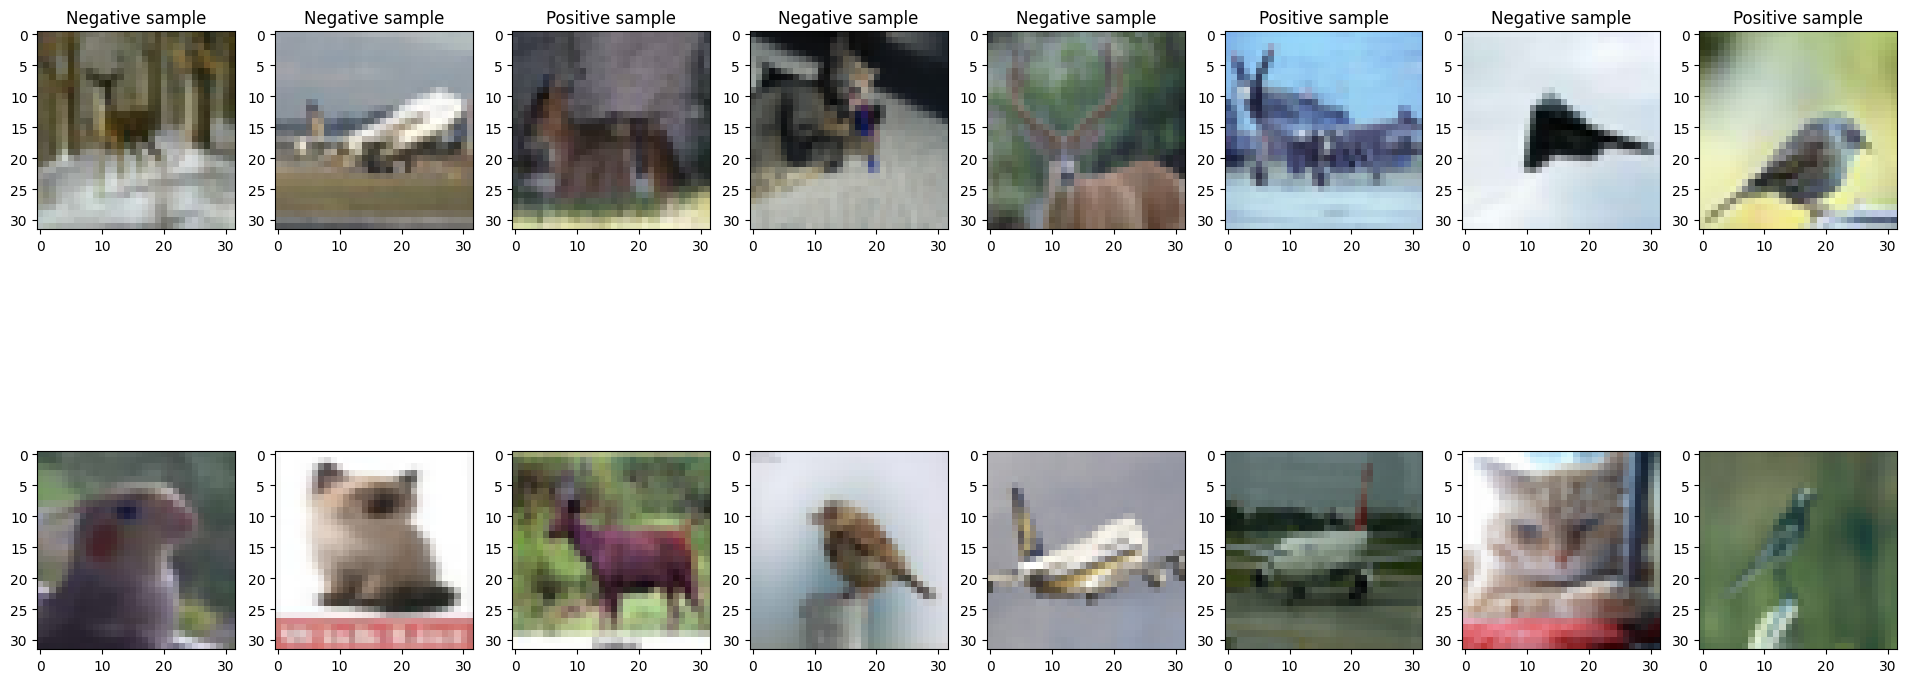

In [20]:
#fig, ax = plt.subplots(nrows = 2, ncols = 8) # 이전과 다르게 subplot "s"임을 주의
plt.figure(figsize = (24, 10))

for i in range(8): # 8번 반복

  plt.subplot(2, 8, i+1) # 총 8개 그림(1행 8열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow((X1[i].detach().numpy()*255).astype(np.uint8)) # index에 해당하는 그림 출력
  
  if int(Y[i].detach().numpy().reshape(-1)[0]) == 1:
    plt.title('Negative sample')
  else:
    plt.title('Positive sample')

  plt.subplot(2, 8, i+9) # 총 8개 그림(1행 8열)을 그리고, 해당 인덱스에 위치시킬 것
  plt.imshow((X2[i].detach().numpy()*255).astype(np.uint8)) # index에 해당하는 그림 출력

#Siamese network 구조 설명

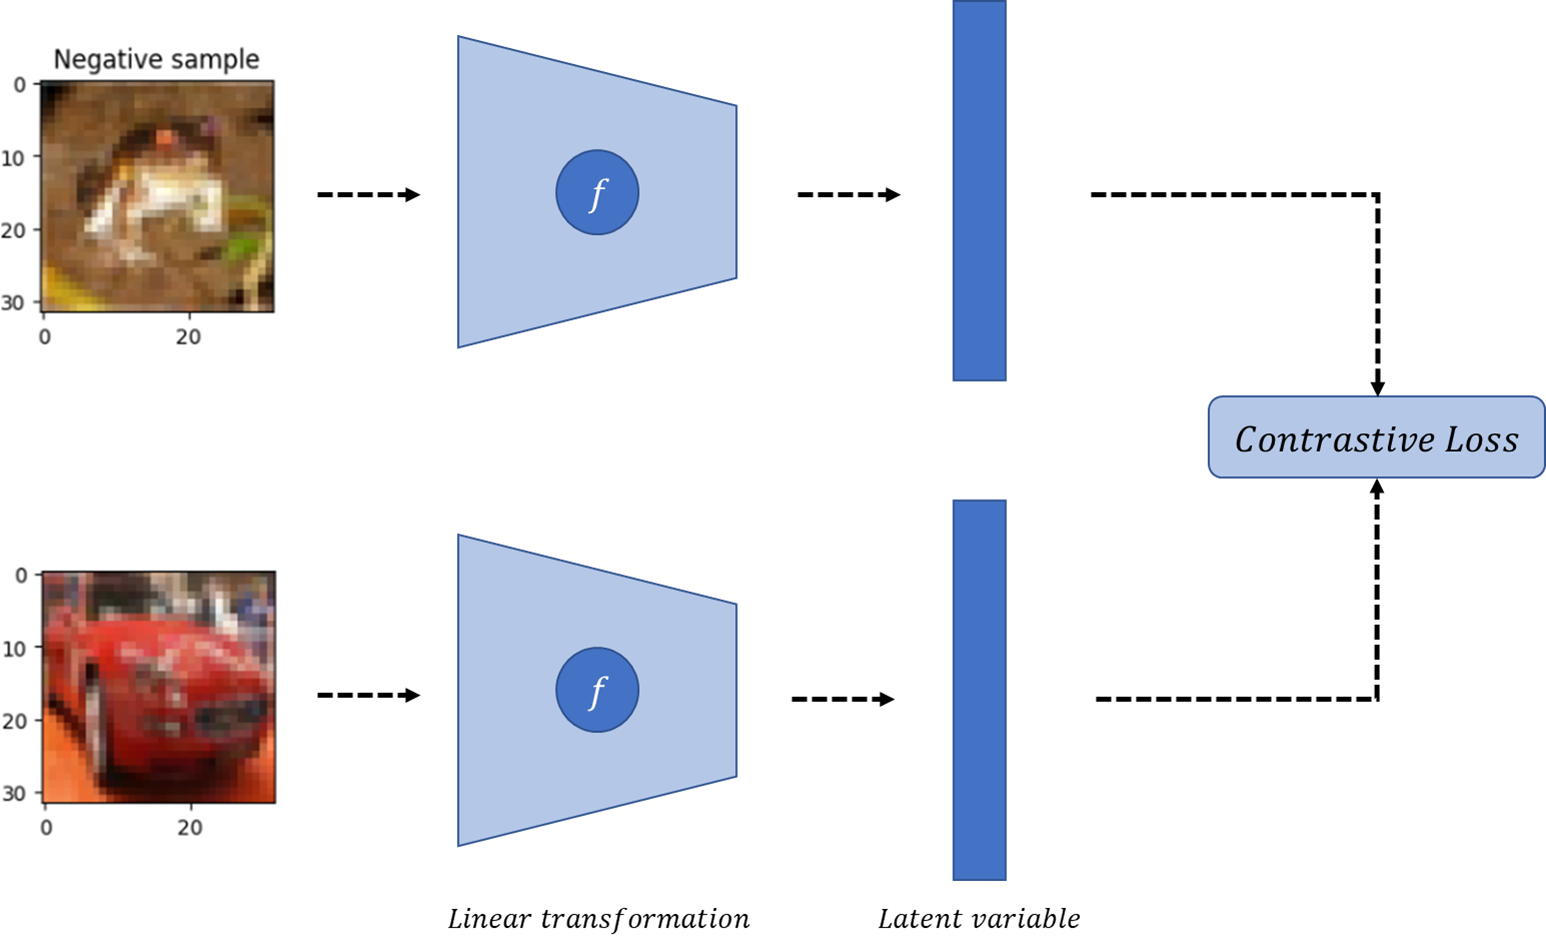

---

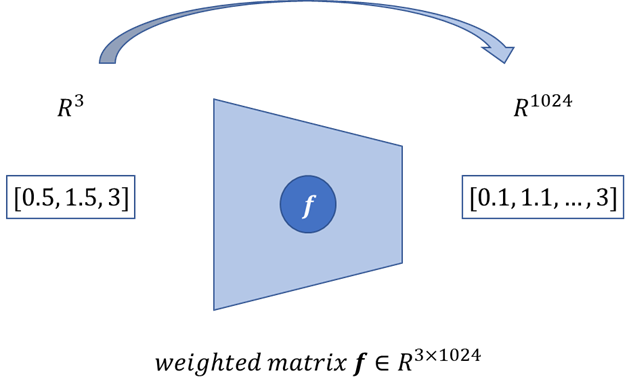

In [21]:
class Siamese(nn.Module):

  def __init__(self):
    super(Siamese, self).__init__()

    '''
    모델 구조
    연산: Conv 1 -> ReLU -> Max Pooling -> Conv 2 -> ReLU -> Max Pooling -> Conv 3 -> ReLU -> Conv 4 -> ReLU -> Conv 5 -> ReLU -> Max Pooling -> 1-D flatten -> Multi Layer Perceptron
      * (두가지 입력 데이터는 동일한 weighted matrix 사용)
      
    결과물: latent variable
    '''

    self.C1 = nn.Conv2d(in_channels = 3, out_channels = 9, kernel_size = 2, stride = 1, padding = 1)
    self.C2 = nn.Conv2d(in_channels = 9, out_channels = 16, kernel_size = 2, stride = 1, padding = 1)
    self.C3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 1, padding = 1)
    self.C4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 1, padding = 1)
    self.C5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 2, stride = 1, padding = 1)

    self.pool = nn.MaxPool2d(kernel_size = 2)

    self.L1 = nn.Linear(128, 512)

    self.L2 = nn.Linear(512, 32)

    self.relu = nn.ReLU()
    
  def forwarding(self, x):

    out = self.C1(x)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C2(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C3(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C4(out)
    out = self.relu(out)
    out = self.pool(out)

    out = self.C5(out)
    out = self.relu(out)
    out = self.pool(out)

    out = out.reshape(-1, 128)

    out = self.L1(out)
    out = self.relu(out)

    out = self.L2(out)

    return out

  def forward(self, x1, x2):

    E1 = self.forwarding(x1)
    E2 = self.forwarding(x2)

    return E1, E2

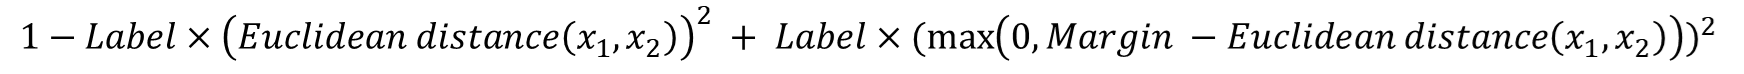

#왜 max(0, Margin - Euclidean distance)를 사용하는지?
* Distance가 만족해야 하는 3가지 가정
 * 삼각부등식 만족
 * 대칭: D(a, b) = D(b, a)
 * ***0보다 항상 커야 함(음의 거리는 존재하지 않음)*** <- max() 함수 원인

##Contrastive Loss
* (A + B 형태로 설명)

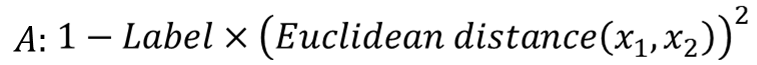

Positive sample을 0이라고 정하면, 1 - Label에 대한 수식만 존재함

이는 입력된 두 데이터의 유클리드 거리이고, 이는 손실함수와 같음

최적화를 통해 손실함수가 0에 수렴하도록 모델의 가중치를 학습한다면

입력된 두 데이터의 거리는 동일한 위치로 변환됨

---

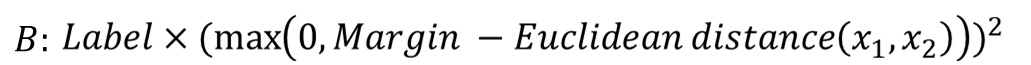

Positive sample이 0이라면, Negative sample이 1이 되므로, 이 경우 Label에 대한 수식만 존재함

두 데이터의 거리를 고정된 절대 값(Margin)으로 수렴시키는 과정을 통해

두 데이터의 거리를 멀어지게 표현할 수 있음

In [22]:
class Contrastive_Loss(nn.Module):

  def __init__(self):
    super(Contrastive_Loss, self).__init__()
    self.margin = 2.0

  def forward(self, output1, output2, label):
    
    '''
    연산은 1-label, label의 두가지가 더해진 형태임

    label = 0인 경우 -> Loss 값은 torch.mean()의 앞쪽 수식인 두 데이터의 유클리디안 거리의 제곱이 계산되며, 이는 0으로 수렴할 것임(Loss가 최소화 되도록 parameter update)

    반대로, label = 1인 경우 -> Loss 값은 self.margin 값으로 수렴함

    positive sample은 label 0과 같고, negative sample은 label 1과 같음

    positive sample의 유클리디안 거리는 0으로 수렴하고, negative sample의 거리는 self.margin(특정 수치, 이 클래스에서는 2로 지정)으로 수렴함
    '''

    euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim = True)
    Loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

    return Loss

In [23]:
net = Siamese() # Siamese network 활용

In [24]:
epochs = 400 # 학습 Cycle을 몇번 반복할 것인지
learning_rate = 0.01 # 도출된 Loss를 어느정도 반영할 것인지
criterion = Contrastive_Loss() # 손실 함수 정의: class로 정의한 Contrastive Loss 사용
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate) # 최적화 함수를 어떤것을 사용할 것인지

In [ ]:
Loss = list()

for epoch in range(epochs):
  net.train()
  for idx, data in enumerate(trainloader):
    
    optimizer.zero_grad()
    
    Sampled_ = data
    X1 = Sampled_[0].squeeze(1).permute(0, 3, 1, 2) # 정의한 신경망에 입력하기 위해 차원 변경
    X2 = Sampled_[1].squeeze(1).permute(0, 3, 1, 2) # 정의한 신경망에 입력하기 위해 차원 변경
    Y = Sampled_[2] # Positive인지, Negative인지를 알려주는 Label

    E1, E2 = net(X1, X2) # 신경망 연산을 통해 X1, X2의 Latent Variable 추출

    loss = criterion(E1, E2, Y) # 손실 함수 계산

    Loss.append(loss.detach().numpy().reshape(1)[0]) # 정의한 List에 손실 함수값 추가

    loss.backward() # 손실 함수값을 바탕으로 역전파 학습 진행

    optimizer.step() # 신경망 파라미터(선형 변환에 사용된 함수의 weight) 최적화

In [ ]:
plt.plot(Loss)

In [ ]:
def convert_key(D_, Label_):
  return D_[Label_]

with torch.no_grad():
  net.eval()

  Latent_vectors = list()
  Animals = list()

  for i, data in enumerate(testloader):

    test_sample = data

    X1 = test_sample[0].squeeze(0).permute(2, 0, 1)
    X2 = test_sample[1].squeeze(0).permute(2, 0, 1)

    X1_emb, X2_emb = net(X1, X2)

    Y1 = d[test_sample[2].detach().numpy().reshape(1)[0]]
    Y2 = d[test_sample[3].detach().numpy().reshape(1)[0]]
    
    Latent_vectors.append(X1_emb.detach().cpu().numpy().reshape(-1))
    Latent_vectors.append(X2_emb.detach().cpu().numpy().reshape(-1))

    Animals.append(Y1)
    Animals.append(Y2)

In [ ]:
Result = pd.DataFrame(Latent_vectors)
Result['Label'] = Animals

In [ ]:
Result

In [ ]:
tsne = TSNE()

xy = tsne.fit_transform(Result.iloc[:, :-1])

Result['x'] = xy[:, 0]
Result['y'] = xy[:, 1]

In [ ]:
sns.scatterplot(x = Result['x'], y = Result['y'], hue = Result['Label'])
plt.legend(loc = 'upper right')

* Convolution Network를 더 정교하거나, 하이퍼 파라미터를 조절하여 성능 개선 가능

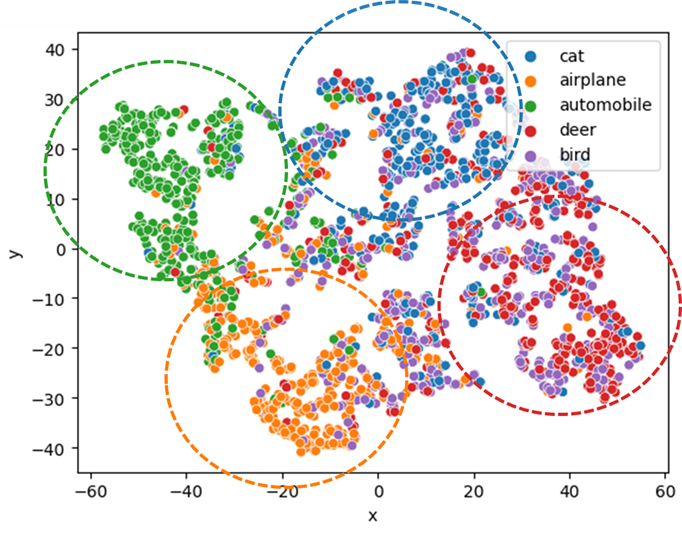

#한계점

---

* Intra-class similarity: class 내에 존재하는 데이터 사이의 유사도(Positive Sample인 경우 문제 발생)
 * 동일한 Sample은 하나의 점에 Mapping -> 동일한 Sample이라도 다양한 특성이 있을 수 있는데, 이를 무시하고 하나의 점으로 표현하는 경우 정보의 손실이 발생할 수 있음
 
---

* Inter-class similarity: class 사이의 유사도(Negative Sample인 경우 문제 발생)
 * Negative Sample은 모두 Margin만큼 멀어지도록 설정하였음.
 * 하지만, ***(강아지, 토끼)*** 의 거리는 ***(강아지, 비행기)*** 의 거리보다 가깝게 설정되어야 함.

---

## 이를 위해 다양한 연구가 진행되고 있음

#활용

**1) K-NN 알고리즘을 활용하여 다중 분류 문제 해결**

**2)  사전 학습된 Latent Variable을 활용하여 다중 분류 문제 해결**

#K-NN

* 입력된 데이터와 거리가 가까운 K개 데이터의 클래스를 기반으로 데이터를 분류

#Latent Variable 활용

* 각 이미지를 (32, 32, 3)의 픽셀 값으로 활용하지 않고, 잠재 공간으로 매핑된 16차원의 벡터를 입력으로 대신 활용하여 예측 모델을 구성